In [13]:
import os
import csv
import random
import pydicom
import numpy as np
import pandas as pd
from skimage import measure
from skimage.transform import resize
from sklearn.model_selection import StratifiedKFold, KFold 
####use KFold to make craoss-validation

In [14]:
###open the label information first

In [15]:
f = open('D:/datamining/RSNA/stage_2_train_labels.csv','r')

In [16]:
"""
the pneumonia locations were listed as bounding boxes
therefore, we create an empyt table for containing the data of bounding box

"""
boundingbox = {}    ###contains the data of each bounding box
box = csv.reader(f)

In [17]:
next(box, None)    ###skip the header
for rows in box:
    filename = rows[0]
    location = rows[1:5]
    pneumonia = rows[5]
    ### if row contains pneumonia add label to dictionary
    ### which contains a list of pneumonia locations per filename
    if pneumonia == '1':
        ### convert string to float to int
        location = [int(float(i)) for i in location]
        ### save pneumonia location in dictionary
        if filename in boundingbox:
            boundingbox[filename].append(location)
        else:
            boundingbox[filename] = [location]

In [18]:
### load and shuffle filenames
folder = 'D:/datamining/RSNA/stage_2_train_images'
filenames = os.listdir(folder)
SEED = 1001
BATCH_SIZE = 8  ### BATCH_SIZE = random.choice([14,15,16,17,18])
IMAGE_SIZE = 320 ### resize images to 320x320 pixels
lr = 0.00042 #### lr = 10**(-4*np.random.rand())
beta = 0.94  ### beta = np.random.uniform(0.9,0.99)

nn_depth = 4
n_epochs = 5
n_splits = 3 ### split the train set into 3 sets, and then use Kfold cross-validation
stratified = True
debug = False

print('learning rate: {}'.format(lr))
print('beta (momentum): {}'.format(beta))
print('batch size: {}'.format(BATCH_SIZE))

labels = pd.read_csv('D:/datamining/RSNA/stage_2_train_labels.csv')
labels = labels.drop(['x', 'y', 'width', 'height'], axis=1)
labels = labels.groupby('patientId', as_index=False).agg('mean')
labels.loc[:,'patientId'] = labels.loc[:,'patientId'] + '.dcm'

if debug == True:
    X = labels['patientId'][:1000].values
    y = labels['Target'][:1000].values
else:
    X = labels['patientId'].values
    y = labels['Target'].values
labels.head()

learning rate: 0.00042
beta (momentum): 0.94
batch size: 8


,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm,0
1,000924cf-0f8d-42bd-9158-1af53881a557.dcm,0
2,000db696-cf54-4385-b10b-6b16fbb3f985.dcm,1
3,000fe35a-2649-43d4-b027-e67796d412e0.dcm,1
4,001031d9-f904-4a23-b3e5-2c088acd19c6.dcm,1


In [19]:
del labels

In [20]:
import tensorflow as tf
from tensorflow import keras

class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, boundingbox=None, batch_size=32, image_size=320, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.boundingbox = boundingbox
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        ### load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        ### create empty mask
        msk = np.zeros(img.shape)
        ### get filename without extension
        filename = filename.split('.')[0]
        ### if image contains pneumonia
        if filename in boundingbox:
            ### loop through pneumonia
            for location in boundingbox[filename]:
                ### add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        ### if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        ### resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        ### add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        ### load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        ### resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        ### add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        ### select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        ### predict mode: return images and filenames
        if self.predict:
            ### load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            ### create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        ### train mode: return images and masks
        else:
            ### load files
            items = [self.__load__(filename) for filename in filenames]
            ### unzip images and masks
            imgs, msks = zip(*items)
            ### create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            ### return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            ### return full batches only
            return int(len(self.filenames) / self.batch_size)

In [21]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=beta)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=beta)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    ###x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=beta)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    ### input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    ### residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    ### output
    x = keras.layers.BatchNormalization(momentum=beta)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(256, 1, activation=None)(x)
    x = keras.layers.BatchNormalization(momentum=beta)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2DTranspose(128, (8,8), (4,4), padding="same", activation=None)(x)
    x = keras.layers.BatchNormalization(momentum=beta)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**(depth-2))(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [22]:

"""
to measure the loss function,  here we use both cross entropy loss（bec loss） and
IoU (iou loss)

"""

def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

### combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)
    
### mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

### create network and compiler
model = create_network(input_size=IMAGE_SIZE, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])


### create network and compiler
model = create_network(input_size=IMAGE_SIZE, channels=32, n_blocks=2, depth=nn_depth)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

### cosine learning rate annealing
def cosine_annealing(x):
    epochs = 20
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

### print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
### load and shuffle filenames
folder = 'D:/datamining/RSNA/stage_2_test_images'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

### create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=True)

def test_pred(test_gen, test_filenames):

    ### create submission dictionary
    submission_dict = {}
    ### loop through testset
    for imgs, filenames in test_gen:
        ### predict batch of images
        preds = model.predict(imgs)

        ### loop through batch
        for pred, filename in zip(preds, filenames):
            
            ### resize predicted mask
            pred = resize(pred, (1024, 1024), mode='reflect')
            ### threshold predicted mask
            comp = pred[:, :, 0] > 0.5
            ### apply connected components
            comp = measure.label(comp)
            ### apply bounding boxes
            predictionString = ''
            for region in measure.regionprops(comp):
                ### retrieve x, y, height and width
                y, x, y2, x2 = region.bbox
                height = y2 - y
                width = x2 - x
                ### proxy for confidence score
                conf = np.mean(pred[y:y+height, x:x+width])
                ### add to predictionString
                predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
            
            ### add filename and predictionString to dictionary
            filename = filename.split('.')[0]
            submission_dict[filename] = predictionString
        ### stop if we've got them all
        if len(submission_dict) >= len(test_filenames):
            break

    print("Done predicting...")
    
    return submission_dict

n test samples: 3000


Instructions for updating:
Use tf.cast instead.
Epoch 1/5
2223/2223 [==============================] - 2441s 1s/step - loss: 3.9551 - acc: 0.9609 - mean_iou: 0.5601 - val_loss: 4.1250 - val_acc: 0.9712 - val_mean_iou: 0.6920
Epoch 2/5
2223/2223 [==============================] - 2256s 1s/step - loss: 3.7467 - acc: 0.9633 - mean_iou: 0.5974 - val_loss: 4.0888 - val_acc: 0.9697 - val_mean_iou: 0.6587
Epoch 3/5
2223/2223 [==============================] - 2261s 1s/step - loss: 3.6621 - acc: 0.9656 - mean_iou: 0.6173 - val_loss: 3.8467 - val_acc: 0.9695 - val_mean_iou: 0.6539
Epoch 4/5
2223/2223 [==============================] - 2253s 1s/step - loss: 3.6083 - acc: 0.9669 - mean_iou: 0.6206 - val_loss: 3.7255 - val_acc: 0.9675 - val_mean_iou: 0.6327
Epoch 5/5
2223/2223 [==============================] - 2294s 1s/step - loss: 3.5563 - acc: 0.9680 - mean_iou: 0.6310 - val_loss: 3.9747 - val_acc: 0.9726 - val_mean_iou: 0.6906
Done predicting...


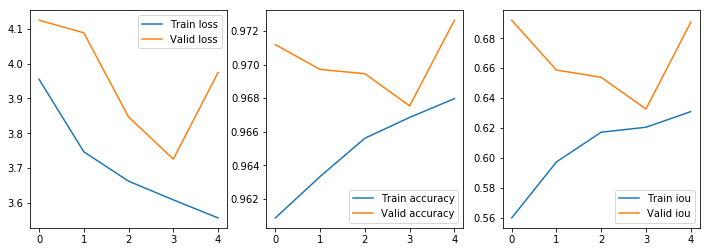

Final epoch train loss = 3.556
Final epoch val loss = 3.975
Final epoch train acc = 0.968
Final epoch val acc = 0.973
Final epoch train mean_iou = 0.631
Final epoch val mean_iou = 0.691
Done predicting...
Epoch 1/5
2223/2223 [==============================] - 2269s 1s/step - loss: 3.5690 - acc: 0.9663 - mean_iou: 0.6268 - val_loss: 3.5891 - val_acc: 0.9644 - val_mean_iou: 0.6281
Epoch 2/5
2223/2223 [==============================] - 2257s 1s/step - loss: 3.5435 - acc: 0.9667 - mean_iou: 0.6222 - val_loss: 3.5747 - val_acc: 0.9649 - val_mean_iou: 0.6397
Epoch 3/5
2223/2223 [==============================] - 2279s 1s/step - loss: 3.5061 - acc: 0.9673 - mean_iou: 0.6340 - val_loss: 3.5325 - val_acc: 0.9731 - val_mean_iou: 0.7230
Epoch 4/5
2223/2223 [==============================] - 2265s 1s/step - loss: 3.4807 - acc: 0.9674 - mean_iou: 0.6318 - val_loss: 3.4636 - val_acc: 0.9714 - val_mean_iou: 0.6780
Epoch 5/5
2223/2223 [==============================] - 2256s 1s/step - loss: 3.4474 - a

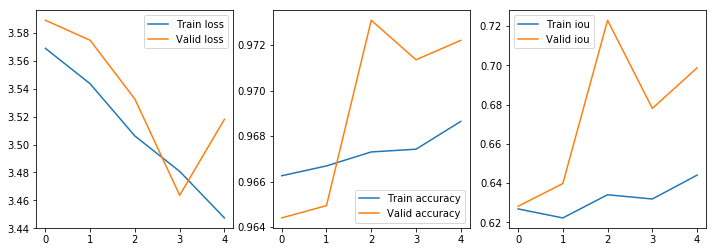

Final epoch train loss = 3.447
Final epoch val loss = 3.518
Final epoch train acc = 0.969
Final epoch val acc = 0.972
Final epoch train mean_iou = 0.644
Final epoch val mean_iou = 0.699
Done predicting...
Epoch 1/5
2223/2223 [==============================] - 2237s 1s/step - loss: 3.4271 - acc: 0.9689 - mean_iou: 0.6540 - val_loss: 3.5393 - val_acc: 0.9654 - val_mean_iou: 0.6268
Epoch 2/5
2223/2223 [==============================] - 2261s 1s/step - loss: 3.3732 - acc: 0.9694 - mean_iou: 0.6654 - val_loss: 3.5104 - val_acc: 0.9714 - val_mean_iou: 0.6902
Epoch 3/5
2223/2223 [==============================] - 2236s 1s/step - loss: 3.3405 - acc: 0.9701 - mean_iou: 0.6702 - val_loss: 3.8326 - val_acc: 0.9489 - val_mean_iou: 0.5628
Epoch 4/5
2223/2223 [==============================] - 2244s 1s/step - loss: 3.3330 - acc: 0.9701 - mean_iou: 0.6724 - val_loss: 3.5451 - val_acc: 0.9642 - val_mean_iou: 0.6484
Epoch 5/5
2223/2223 [==============================] - 2282s 1s/step - loss: 3.3195 - a

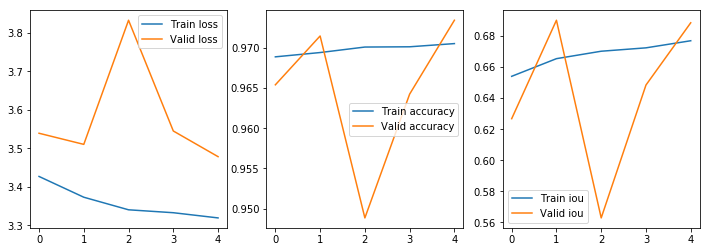

Final epoch train loss = 3.319
Final epoch val loss = 3.478
Final epoch train acc = 0.971
Final epoch val acc = 0.973
Final epoch train mean_iou = 0.677
Final epoch val mean_iou = 0.689
Done predicting...


In [13]:
from matplotlib import pyplot as plt

"""
### create train and validation generators
####use KFold to make craoss-validation

"""
folder = 'D:/datamining/RSNA/stage_2_train_images'

if stratified == True:
    skf = StratifiedKFold(n_splits=n_splits, random_state=SEED)
    for n_fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        train_gen = generator(folder, X[train_idx], boundingbox, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)
        valid_gen = generator(folder, X[val_idx], boundingbox, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)
        history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=n_epochs, shuffle=True)
        
        valid_gen = generator(folder, X[val_idx], boundingbox, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=True)
        oof_dict = test_pred(valid_gen, X[val_idx])
        
        ### save dictionary as csv file
        oof = pd.DataFrame.from_dict(oof_dict,orient='index')
        oof.index.names = ['patientId']
        oof.columns = ['PredictionString']
        oof.to_csv('oof_preds' + str(n_fold) + '.csv')
        
        plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.plot(history.epoch, history.history["loss"], label="Train loss")
        plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
        plt.legend()
        plt.subplot(132)
        plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
        plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
        plt.legend()
        plt.subplot(133)
        plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
        plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
        plt.legend()
        plt.show()
        print('Final epoch train loss = {:.3f}'.format(history.history['loss'][-1]))
        print('Final epoch val loss = {:.3f}'.format(history.history['val_loss'][-1]))
        print('Final epoch train acc = {:.3f}'.format(history.history['acc'][-1]))
        print('Final epoch val acc = {:.3f}'.format(history.history['val_acc'][-1]))
        print('Final epoch train mean_iou = {:.3f}'.format(history.history['mean_iou'][-1]))
        print('Final epoch val mean_iou = {:.3f}'.format(history.history['val_mean_iou'][-1]))
        
        sub_dict = test_pred(test_gen, test_filenames)
        
        ### save dictionary as csv file
        sub = pd.DataFrame.from_dict(sub_dict,orient='index')
        sub.index.names = ['patientId']
        sub.columns = ['PredictionString']
        sub.to_csv('submission' + str(n_fold) + '.csv')
        
else:
    kf = KFold(n_splits=n_splits, random_state=SEED)
    for n_fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        train_gen = generator(folder, X[train_idx], boundingbox, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)
        valid_gen = generator(folder, X[val_idx], boundingbox, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)
        history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=n_epochs, shuffle=True)
        
        valid_gen = generator(folder, X[val_idx], boundingbox, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=True)
        oof_dict = test_pred(valid_gen, X[val_idx])
        
        ### save dictionary as csv file
        oof = pd.DataFrame.from_dict(oof_dict,orient='index')
        oof.index.names = ['patientId']
        oof.columns = ['PredictionString']
        oof.to_csv('oof_preds' + str(n_fold) + '.csv')
        
        plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.plot(history.epoch, history.history["loss"], label="Train loss")
        plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
        plt.legend()
        plt.subplot(132)
        plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
        plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
        plt.legend()
        plt.subplot(133)
        plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
        plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
        plt.legend()
        plt.show()
        print('Final epoch train loss = {:.3f}'.format(history.history['loss'][-1]))
        print('Final epoch val loss = {:.3f}'.format(history.history['val_loss'][-1]))
        print('Final epoch train acc = {:.3f}'.format(history.history['acc'][-1]))
        print('Final epoch val acc = {:.3f}'.format(history.history['val_acc'][-1]))
        print('Final epoch train mean_iou = {:.3f}'.format(history.history['mean_iou'][-1]))
        print('Final epoch val mean_iou = {:.3f}'.format(history.history['val_mean_iou'][-1]))
        
        sub_dict = test_pred(test_gen, test_filenames)
        
        ### save dictionary as csv file
        sub = pd.DataFrame.from_dict(sub_dict,orient='index')
        sub.index.names = ['patientId']
        sub.columns = ['PredictionString']
        sub.to_csv('submission' + str(n_fold) + '.csv')

In [14]:
sub

,PredictionString
patientId,
0000a175-0e68-4ca4-b1af-167204a7e0bc,
0005d3cc-3c3f-40b9-93c3-46231c3eb813,
000686d7-f4fc-448d-97a0-44fa9c5d3aa6,
000e3a7d-c0ca-4349-bb26-5af2d8993c3d,
00100a24-854d-423d-a092-edcf6179e061,0.5759344638895266 270 651 76 90
0015597f-2d69-4bc7-b642-5b5e01534676,
001b0c51-c7b3-45c1-9c17-fa7594cab96e,
0022bb50-bf6c-4185-843e-403a9cc1ea80,
00271e8e-aea8-4f0a-8a34-3025831f1079,
